In [1]:
import numpy as np #Biblioteka służąca do obliczeń
import math #funkcje matematyczne sqrt/ potęgi itd.
import random #liczby pseudolosowe
import pandas as pd #analiza danych
import matplotlib.pyplot as plt #wykresy
import seaborn as sns #analiza statystyczna 

In [2]:
iris = pd.read_csv("iris.csv") #wczytanie bazy irysów

In [3]:
iris.head() #5 pierwszych rekordów
iris.describe() #opis 
iris.info() #info o bazie z csv
iris #wypisanie bazy

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


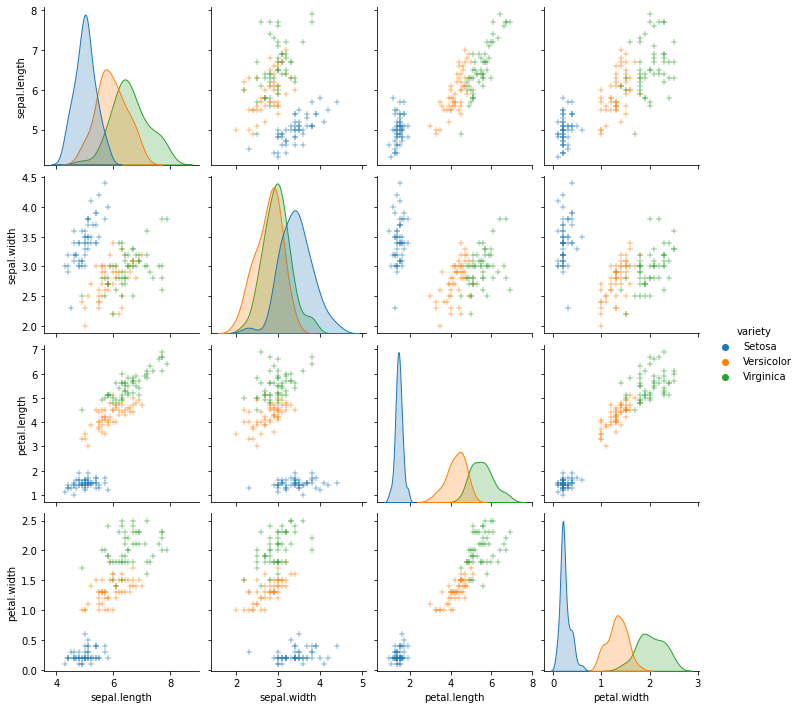

In [4]:
#Wykres parowy
sns.pairplot(iris, hue='variety', markers="+") #hue -> zmienna w naszym przypadku gatunek kwiata
                                               #markers -> reprezentacja punktu, w naszym przpypadku w formie +

#Interpretacja
#Z wykresów punktowych możemy odczytać, że algorytm nie powinien mieć problemu z nauczeniem rozpoznawania się odmiany Setosa
#Jest to spowodowane rozproszeniem danych na wykresach, gdzie można poprawidzić np. wyraźną prostą pomiędzy Setosą, a pozostałymi odmianami
#Wykresy kolumnowe -?

<AxesSubplot:xlabel='sepal.length', ylabel='variety'>

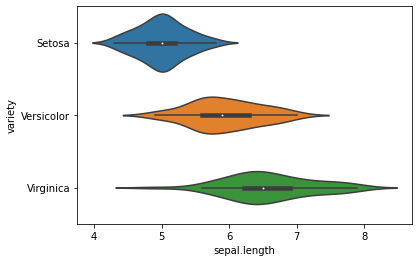

In [5]:
#Wykres wiolinowy
sns.violinplot(y='variety', x='sepal.length', data=iris) #OSY -> odmiana, OSX -> długość dzwonka
#Z wykresu możemy stwierdzić, że mediana setosy przypada na 5 jd dzwonka i to w tym obszarze jest największe zagęszczenie danych
#Im szerszy wykres w danym miejscu, to stwierdzamy, że więcej obiektów reprezentuje daną ceche



In [6]:
#Klasa przetwarzania danych
# 1) Tasowanie danych
# 2) Podział zbioru na walidacyjny i treningowy 70%/30%
# 3) Normalizacja

class DataProcessing:
    #Tasowanie
    @staticmethod #Zdeklarowanie metody, jako statycznej
    def shuffle(x):
        for i in range(0, len(x), 1): #Iterujemy, cały zbiór co jeden
            j = random.randint(i, len(x)-1) #randomowa liczba z i do len(x) - 1
            x.iloc[i], x.iloc[j] = x.iloc[j], x.iloc[i] #.iloc -> Wyciągamy i-ty rząd oraz j-ty rząd, zamieniamy miejscami
        return x

    #Podział zbioru 70/30
    @staticmethod
    def split(x):
        brd = math.ceil(.7*len(x)) #70% długośc zbioru ceil(od 0 do x)
        train = x[:brd] #zbior treningowy -od 0 do 70%
        val = x[brd:] #zbior walidacyjny - od 70% do 100%
        return train, val
    
    #Normalizacja
    @staticmethod
    def normalize(x):
        df = pd.DataFrame(x) #zoobrazowanie danych w formie tabeli
        normalized = (df - df.min())/(df.max - df.min()) #wzor z wykładów
        return normalized.to_numpy() #konwersja danych do tablicy


In [7]:
#Algorytm KNN (K najblizszych sasiadow) k nearest neighbours
class KNN:
    #Funkcja odległości
    @staticmethod
    def euclideanMetric(v1, v2): #Oblicza odległość pomiędzy wektorami v1 oraz v2
        distance = 0
        for i in range(0, len(v1)-1):
            distance += (v1[i] - v2[i]) ** 2 #do kwadratu
        return distance ** (1/2) #Zwracamy pierwiastek z distance / Zwykład odległość Euklidesowa

    
    #Klasteryzacja KNN
    def clusetring(x, sample, k, classes): #x-zbior treningowy, sample-probka, k-ilosc sasiadow, classes - słownik zliczający wystapięnia irysow
        distances = [] #Tablica zawierająca odległości
        
        #obliczenie odległości
        for i in range(0, len(x)):
            distances.append(KNN.euclideanMetric(sample, x.iloc[i])) #Mierzymy odległości między próbką, a każdym rzędem w bazie
        
        #Sortowanie danych
        for i in range(0, len(distances)-1):
            for j in range(0, len(distances)-i-1):
                if distances[j] > distances[j+1]: #jezeli poprzednia warotsc jest wieksza
                    distances[j], distances[j+1] = distances[j+1], distances[j] #zamieniamy je miejscami w tablicu
                    x.iloc[j], x.iloc[j+1] = x.iloc[j+1], x.iloc[j]             #zamieniamy wiersze, z ktorych pochodzily
                    
        #Glosowanie
        for i in range(0, k): #glosujemy tyle ile jest sasidow
            classes[x.iloc[i][4]] += 1 #dostajemy sie do nazwy kwiatka, ze slownika odmian, inkrementujemy wartosci w slowniku, po dostaniu sie przez nazwe odmiany irysa
            
        #zwracanie
        return max(classes, key=classes.get) #Zwroci maksymalna wartosc liczbowa przypisana do typu kwiatka w slowniku

    
    #Zliczanie dokładności
    def calcAccuracy(val, train, k, classes):
        corrected = 0 #Liczba poprawnych na starcie
        for i in range(0, len(val)): #iterujemy przez wszystkie ze zbioru walidacyjnego
            if KNN.clusetring(train, val.iloc[i], k, classes) == val.iloc[i][4]: #Jezeli wynik zwrocny z glosowania jest prawdziwy
                corrected += 1
        accuracy = corrected/len(val) * 100
        return accuracy
    

In [8]:
k = 3 #liczba sasiadow
classes = {'Setosa':0, 'Virginica':0, 'Versicolor':0} #Slownik irysow
irisShuffled = DataProcessing.shuffle(iris)
train, val = DataProcessing.split(irisShuffled)
accuracy = KNN.calcAccuracy(val, train, k, classes)

print(f'Skuteczność testu dla {k} sąsiadów, wynosiła: {accuracy} %')

#Skuteczność dla dwóch sąsiadów 48,88888...%
#Skuteczność dla trzech sąsiadów 37,77777...%

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1760: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


Skuteczność testu dla 3 sąsiadów, wynosiła: 44.44444444444444 %


In [9]:
iris.describe()

,sepal.length,sepal.width,petal.length,petal.width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [10]:
shuffledIris = DataProcessing.shuffle(iris)
train, val =  DataProcessing.split(shuffledIris)

In [11]:
train

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.3,1.7,0.5,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,6.7,3.1,5.6,2.4,Virginica
3,5.0,2.3,3.3,1.0,Versicolor
4,6.1,3.0,4.6,1.4,Versicolor
...,...,...,...,...,...
100,6.6,2.9,4.6,1.3,Versicolor
101,5.6,2.9,3.6,1.3,Versicolor
102,5.4,3.7,1.5,0.2,Setosa
103,6.9,3.1,5.4,2.1,Virginica


In [12]:
val

,sepal.length,sepal.width,petal.length,petal.width,variety
105,4.4,2.9,1.4,0.2,Setosa
106,5.0,3.4,1.6,0.4,Setosa
107,4.8,3.4,1.9,0.2,Setosa
108,5.2,3.5,1.5,0.2,Setosa
109,6.4,2.7,5.3,1.9,Virginica
110,4.7,3.2,1.6,0.2,Setosa
111,5.5,2.4,3.8,1.1,Versicolor
112,5.6,3.0,4.1,1.3,Versicolor
113,4.6,3.4,1.4,0.3,Setosa
114,5.1,3.8,1.5,0.3,Setosa
